In [59]:
%matplotlib inline
import numpy as np
import sys, scipy
import matplotlib.pyplot as plt
from sklearn.feature_extraction import image
import librosa

sys.path.append('../src')
import laplacian
import RecurrenceMatrix as RM

# Create pseudo-signal
- Since default frequency is 22050, and therefore the cycle for each is 22050 data points

(441000,)


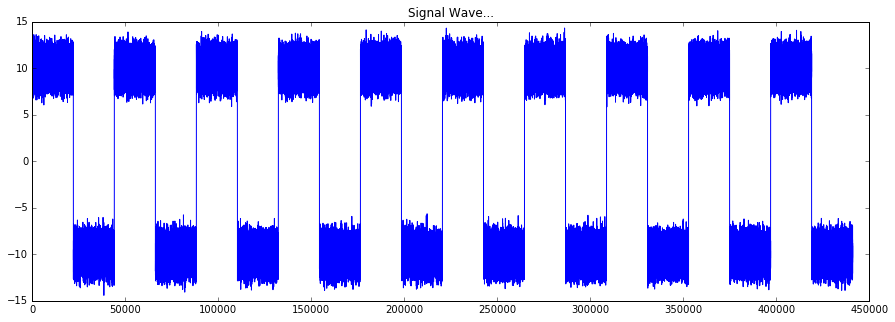

In [114]:
mu, sigma, length = 10, 1, 22050 # mean and standard deviation

signal = []
for i in xrange(20):
    if i%2==0:
        signal += list(np.random.normal(base, sigma, length))
    else:
        signal += list(np.random.normal(-base, sigma, length))
signal = np.array(signal)

print signal.shape
plt.figure(figsize=(15, 5))
plt.title('Signal Wave...')
plt.plot(signal)
plt.ylim((-15,15))
plt.show()

# Convert time signal to feature vector

In [115]:
cqt = np.transpose(librosa.cqt(signal))
print signal.shape, cqt.shape

(441000,) (862, 84)


# Constructing gaussian matrix
-- based on method of w[i,j] = exp(- norm2(x_i-x_j)^2/sigma^2), where x_i, x_j is feature at each time point, sigma is the parameter to learn

In [116]:
gm = RM.feature2GaussianMatrix(cqt, 1.5)
print gm.shape
print "is symmetric: ", (gm==np.transpose(gm)).all()

(862, 862)
is symmetric:  True


# Laplacian --> Eigenvectors

(862, 10)


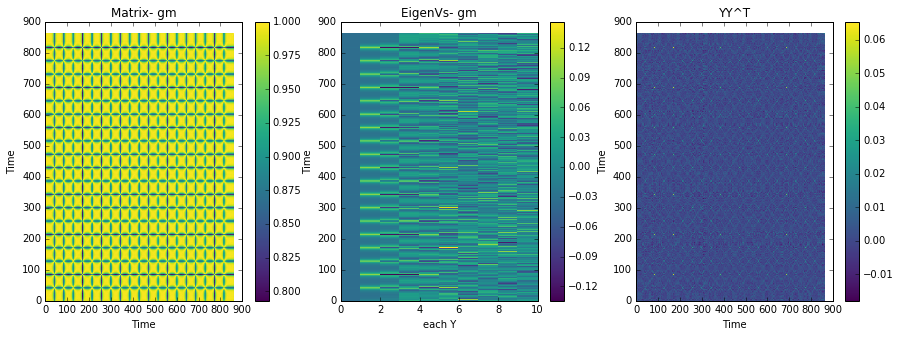

In [117]:
Y = laplacian.getNormLaplacian(gm, 10) #similarity matrix, top m eigenvectors
YY = np.dot(Y[:,:], np.transpose(Y)[:,:])
print Y.shape
plt.figure(figsize=(15, 5))

plt.subplot(1, 3, 1)
plt.pcolor(gm, cmap="viridis")
plt.colorbar()
plt.title('Matrix- gm')
plt.xlabel('Time')
plt.ylabel('Time')

plt.subplot(1, 3, 2)
plt.pcolor(Y, cmap="viridis")
plt.colorbar()
plt.title('EigenVs- gm')
plt.xlabel('each Y')
plt.ylabel('Time')

plt.subplot(1, 3, 3)
plt.pcolor(YY, cmap="viridis")
plt.colorbar()
plt.title('YY^T')
plt.ylabel('Time')
plt.xlabel('Time')
plt.show()

# Laplacina --> Eigenvectors --> Boundary Detection
-- As there are 20 cycles, and actually 40 signal transitions, boundary detection can get 40 bounday lines

[30, 55, 73, 100, 115, 142, 159, 185, 202, 228, 245, 271, 289, 314, 330, 358, 374, 401, 417, 443, 460, 487, 503, 530, 545, 546, 547, 573, 589, 616, 633, 659, 676, 702, 719, 746, 762, 788, 805, 832]


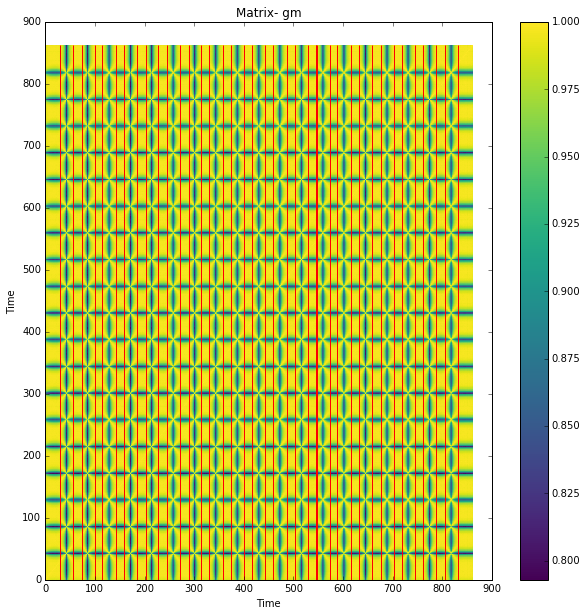

In [119]:
from sklearn.cluster import KMeans
nCluster = 2
Y3 = laplacian.getNormLaplacian(gm, 10) #similarity matrix, top m eigenvectors

def boundaryDetection(Y, nCluster):
    row_leng = np.linalg.norm(Y, axis=1) #get length of each row
    row_leng[row_leng==0] = 1 #replace the legth of 0 to 1
    Y_norm = Y / row_leng[:, np.newaxis]

    clf = KMeans(n_clusters=nCluster, max_iter=100).fit(Y_norm)
    centroids, labels = clf.cluster_centers_, clf.labels_

    boundary = []
    for idx in xrange(len(labels)-1):
        if labels[idx] != labels[idx+1]:
            boundary += [idx]
    
    return boundary, centroids

b, c = boundaryDetection(Y3, nCluster)
print b

plt.figure(figsize=(10, 10))
plt.pcolor(gm, cmap="viridis")
plt.colorbar()
plt.vlines(b, 0, 862, color='r')
plt.title('Matrix- gm')
plt.xlabel('Time')
plt.ylabel('Time')

# Frame to time
-- Convert boundary time frame to time

In [120]:
print b
print librosa.frames_to_time(b)

[30, 55, 73, 100, 115, 142, 159, 185, 202, 228, 245, 271, 289, 314, 330, 358, 374, 401, 417, 443, 460, 487, 503, 530, 545, 546, 547, 573, 589, 616, 633, 659, 676, 702, 719, 746, 762, 788, 805, 832]
[  0.69659864   1.27709751   1.69505669   2.32199546   2.67029478
   3.29723356   3.69197279   4.29569161   4.69043084   5.29414966
   5.68888889   6.29260771   6.71056689   7.29106576   7.66258503
   8.31274376   8.68426304   9.31120181   9.68272109  10.28643991
  10.68117914  11.30811791  11.67963719  12.30657596  12.65487528
  12.67809524  12.70131519  13.30503401  13.67655329  14.30349206
  14.69823129  15.30195011  15.69668934  16.30040816  16.69514739
  17.32208617  17.69360544  18.29732426  18.69206349  19.31900227]
